<html><head><meta content="text/html; charset=UTF-8" http-equiv="content-type"><style type="text/css">ol</style></head><body class="c5"><p class="c0 c4"><span class="c3"></span></p><p class="c2 title" id="h.rrbabt268i6e"><h1>CaImAn&rsquo;s Demo pipeline</h1></p><p class="c0"><span class="c3">This notebook will help to demonstrate the process of CaImAn and how it uses different functions to denoise, deconvolve and demix neurons from a Calcium Imaging Video. </span></p>
<p><img src="docs/img/quickintro.png" /></p>
<p class="c0"><span class="c3">More information can be found in CaImAn&rsquo;s documentation. </span></p>
</html>



In [21]:
#!/usr/bin/env python
from __future__ import division
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import map
from builtins import range
from past.utils import old_div
try:
    get_ipython().magic(u'load_ext autoreload')
    get_ipython().magic(u'autoreload 2')    
except:
    print('Not IPYTHON')
import numpy as np
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib qt')   
import caiman as cm
from caiman.source_extraction import cnmf
from caiman.utils.utils import download_demo
from caiman.utils.visualization import inspect_correlation_pnr
from caiman.components_evaluation import estimate_components_quality_auto
from caiman.motion_correction import motion_correct_oneP_rigid
import os
import cv2
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour

try:
    cv2.setNumThreads(1)
except:
    print('Open CV is naturally single threaded')
import bokeh.plotting as bpl
bpl.output_notebook()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

### Setup some parameters
many of them will be set directly calling the CNMF object

In [22]:
folder = '/home/sebastian/Documents/data/CalcImag/test_session_dsampled/'

fname = [folder+f for f in os.listdir(folder) if ('recording' in f and '.tif' in f)]
print(fname)
frate = 10 # movie frame rate
gSig = 3   # gaussian width of a 2D gaussian kernel, which approximates a neuron
gSiz = 10  # average diameter of a neuron
do_motion_correction = True

['/home/sebastian/Documents/data/CalcImag/test_session_dsampled/32364_active-recording_20170710_120637-002.tif', '/home/sebastian/Documents/data/CalcImag/test_session_dsampled/32364_active-recording_20170710_120637-003.tif', '/home/sebastian/Documents/data/CalcImag/test_session_dsampled/32364_active-recording_20170710_120637-001.tif', '/home/sebastian/Documents/data/CalcImag/test_session_dsampled/32364_active-recording_20170710_120637-004.tif', '/home/sebastian/Documents/data/CalcImag/test_session_dsampled/32364_active-recording_20170710_120637-000.tif']


Download the dataset if not already present

In [23]:
m_raw = cm.load_movie_chain(sorted(fname))
downsample_ratio = 0.2
offset_mov = -np.min(m_raw[:100]).astype(np.float32)  # make the dataset mostly non-negative
#m_raw.resize(1, 1, downsample_ratio).play(
#gain=2, offset=offset_mov, fr=30, magnification=1)

100%|██████████| 5/5 [00:02<00:00,  2.03it/s]


Crop stationary edges:

In [24]:

m_orig = m_raw.interactive_crop(
    gain=1, offset = -offset_mov, fr=30)   # play movie (press q to exit

offset_mov = np.min(m_orig[:100])
m_orig.save('cropped_combined.tif')

Select region, press [c] to crop
cropping at(124, 16),(556, 426)...
124 556 16 426
.tif
tifffile package not found, using skimage instead for imsave


In [25]:
m_orig.shape

(3225, 409, 431)

### (Re)start cluster.  

In [6]:
try:
    dview.terminate() # stop it if it was running
except:
    pass

c, dview, n_processes = cm.cluster.setup_cluster(backend='local', # use this one
                                                 n_processes=16,  # number of process to use, if you go out of memory try to reduce this one
                                                 )

0
0
0
0
0
0
0
0
0
0
10
10
10
10
10
10
10
10
20
10
10
20
20
20
20
20
20
20
30
30
30
20
20
30
30
30
30
30
40
40
40
30
40
30
50
40
40
50
40
50
40
40
50
60
50
40
60
50
50
50
70
60
60
60
50
50
70
80
60
70
60
60
70
80
60
80
90
70
70
70
60
70
90
90
70
80
100
80
70
80
80
100
80
110
80
100
90
90
80
90
110
90
120
90
90
110
100
90
100
120
100
130
100
100
110
100
100
110
140
120
110
130
110
120
110
110
150
120
110
130
120
140
120
160
130
130
120
120
120
130
140
150
170
130
140
140
130
130
160
150
130
140
140
180
140
150
150
140
170
150
160
150
140
160
150
160
190
150
180
170
200
150
170
170
190
160
160
160
160
180
210
160
180
200
170
170
180
170
190
170
170
190
210
220
180
200
180
180
190
180
180
220
230
190
200
190
200
190
210
190
190
200
240
210
230
200
200
220
210
200
210
200
250
240
210
220
230
210
220
250
210
220
220
260
240
210
230
260
230
220
220
250
230
270
230
240
220
270
240
230
230
260
240
280
240
250
280
230
250
240
240
250
270
290
250
290
260
260
250
240
250
260
300
280
260
300
270
26

### Creation of a memory mappable file. 
    - Performs motion correction and simultaneously creates a memory mappable file in F order
    - Transforms into C order (much more efficient for parallel processing
    - If you have multiple files there are ways to process many at the same time (not shown)
    

Play the movie (optional). This will require loading the movie in memory which in general is not needed by the pipeline. Displaying the movie uses the OpenCV library. Press `q` to close the video panel. **BEWARE** the movie may appear in the background!

Rigid Motion Correction
2.502923
-0.3936929726600647


/home/sebastian/Documents/CaImAn/caiman/base/movies.py:260: UserWarning: ** Pixels averages are too negative. Removing 1 percentile. **
  '** Pixels averages are too negative. Removing 1 percentile. **')
/home/sebastian/Documents/CaImAn/caiman/base/movies.py:279: UserWarning: Pixels averages are too negative for template. Removing 1 percentile.
  'Pixels averages are too negative for template. Removing 1 percentile.')


Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
-0.3936929726600647
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
-0.3936929726600647
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
cubic interpolation
Frame 100
Frame 200
Frame 300
Frame 400
Frame 500
Frame 600
Adding to movie 2.502923
0
saving!
** Startting parallel motion correction **
** Finished parallel motion correction **
0.26649645
cropped_combined_rig__d1_450_d2_474_d3_1_order_F_frames_3225_.mmap
loading in memory
mmap


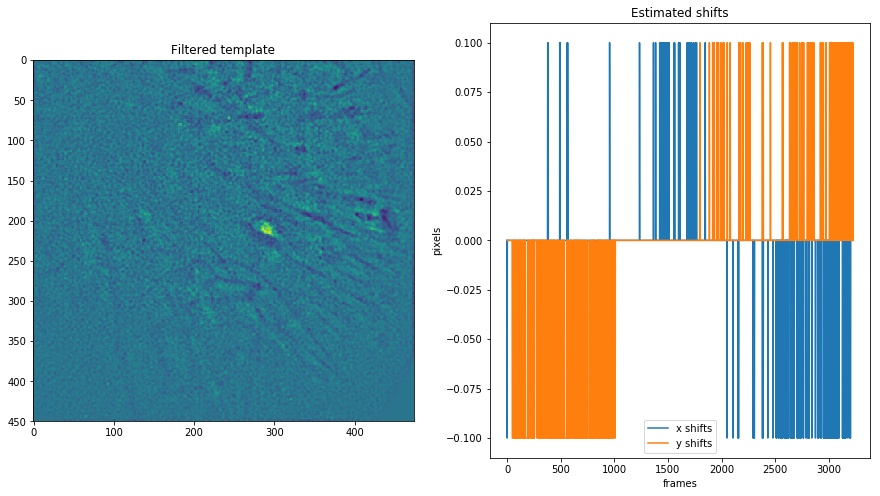

In [7]:
if do_motion_correction:
    mc = motion_correct_oneP_rigid('cropped_combined.tif',                        # name of file to motion correct
                               gSig_filt = [gSig]*6,                 # size of filter, xhange this one if algorithm does not work 
                               max_shifts = [5,5],                   # maximum shifts allowed in each direction 
                               dview=dview, 
                               splits_rig = 10,                      # number of chunks for parallelizing motion correction (remember that it should hold that length_movie/num_splits_to_process_rig>100) 
                               save_movie = True)                    # whether to save movie in memory mapped format
    
    new_templ = mc.total_template_rig
    plt.figure(figsize=(15,8))
    plt.subplot(1,2,1)    
    plt.title('Filtered template')
    plt.imshow(new_templ)       #% plot template
    plt.subplot(1,2,2)
    plt.title('Estimated shifts')
    plt.plot(mc.shifts_rig)     #% plot rigid shifts
    plt.legend(['x shifts', 'y shifts'])
    plt.xlabel('frames')
    plt.ylabel('pixels')
    
    bord_px_rig = np.ceil(np.max(mc.shifts_rig)).astype(np.int)     #borders to eliminate from movie because of motion correction        
    fname_new = cm.save_memmap(mc.fname_tot_rig, base_name='memmap_', order = 'C') # transforming memoruy mapped file in C order (efficient to perform computing)
else:
    #% create memory mappable file
    fname_new = cm.save_memmap(fname, base_name='memmap_', order = 'C')

# load memory mappable file
Yr, dims, T = cm.load_memmap(fname_new)
Y = Yr.T.reshape((T,) + dims, order='F')

In [8]:
m_orig = cm.movie(Y)
downsample_ratio = 1.
offset_mov = -np.min(m_orig[:100])  # make the dataset mostly non-negative
m_orig.resize(1, 1, downsample_ratio).play(
gain=1, offset=offset_mov, fr=30, magnification=1)

### Inspect summary images and set parameters
Check the optimal values of min_corr and min_pnr by moving slider in the figure that pops up

/home/sebastian/anaconda3/envs/caiman/lib/python3.6/site-packages/numpy/core/_methods.py:138: RuntimeWarning: invalid value encountered in sqrt
  ret = um.sqrt(ret, out=ret)


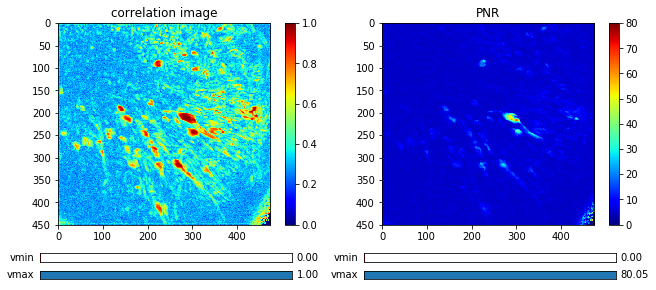

In [10]:
# compute some summary images (correlation and peak to noise)
cn_filter, pnr = cm.summary_images.correlation_pnr(Y, gSig=gSig, swap_dim=False) # change swap dim if output looks weird, it is a problem with tiffile
# inspect the summary images and set the parameters
inspect_correlation_pnr(cn_filter,pnr)


In [12]:
%%capture
#% compute metrics for the results (TAKES TIME!!)
final_size = np.subtract(mc.total_template_rig.shape, 2 * 3) # remove pixels in the boundaries
winsize = 100
swap_dim = False
resize_fact_flow = .2    # downsample for computing ROF

tmpl_rig, correlations_orig, flows_orig, norms_orig, crispness_orig = cm.motion_correction.compute_metrics_motion_correction(
    fname[0], final_size[0], final_size[1], swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

tmpl_rig, correlations_rig, flows_rig, norms_rig, crispness_rig = cm.motion_correction.compute_metrics_motion_correction(
    mc.fname_tot_rig[0], final_size[0], final_size[1],
    swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

# tmpl_els, correlations_els, flows_els, norms_els, crispness_els = cm.motion_correction.compute_metrics_motion_correction(
#     mc.fname_tot_els[0], final_size[0], final_size[1],
#     swap_dim, winsize=winsize, play_flow=False, resize_fact_flow=resize_fact_flow)

AttributeError: 'MotionCorrect' object has no attribute 'fname_tot_els'

In [18]:
# print crispness values
print('Crispness original: '+ str(int(crispness_orig)))
print('Crispness rigid: '+ str(int(crispness_rig)))

Crispness original: 1220
Crispness rigid: 1245


['flows', 'norms', 'correlations', 'smoothness', 'tmpl', 'smoothness_corr', 'img_corr']
cropped_combined_rig__d1_450_d2_474_d3_1_order_F_frames_3225_._metrics.npz
78.55959+/-179.35052 ; 1245.0784 ; nan
mmap


FileNotFoundError: [Errno 2] No such file or directory: 'cropped_combined_metrics.npz'

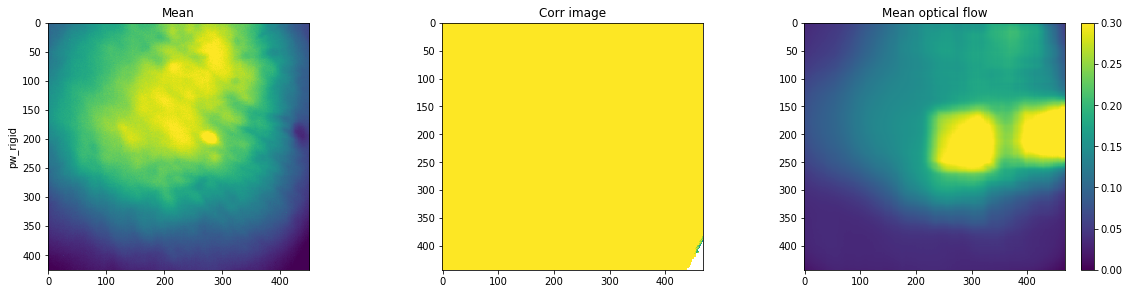

In [20]:
#%% plot the results of Residual Optical Flow
fls = [ mc.fname_tot_rig[0][:-4] +
       '_metrics.npz', mc.fname[0][:-4] + '_metrics.npz']

#print('Running time rigid motion: ' + str(t_rigid))
#print('Running time piecewise motion: ' + str(t_pw))

plt.figure(figsize = (20,10))
for cnt, fl, metr in zip(range(len(fls)),fls,['pw_rigid','rigid','raw']):
    with np.load(fl) as ld:
        print(ld.keys())
        print(fl)
        print(str(np.mean(ld['norms'])) + '+/-' + str(np.std(ld['norms'])) +
              ' ; ' + str(ld['smoothness']) + ' ; ' + str(ld['smoothness_corr']))
        
        plt.subplot(len(fls), 3, 1 + 3 * cnt)
        plt.ylabel(metr)
        try:
            mean_img = np.mean(
            cm.load(fl[:-12] + 'mmap'), 0)[12:-12, 12:-12]
        except:
            try:
                mean_img = np.mean(
                    cm.load(fl[:-12] + '.tif'), 0)[12:-12, 12:-12]
            except:
                mean_img = np.mean(
                    cm.load(fl[:-12] + 'hdf5'), 0)[12:-12, 12:-12]
                    
        lq, hq = np.nanpercentile(mean_img, [.5, 99.5])
        plt.imshow(mean_img, vmin=lq, vmax=hq)
        plt.title('Mean')
        plt.subplot(len(fls), 3, 3 * cnt + 2)
        plt.imshow(ld['img_corr'], vmin=0, vmax=.35)
        plt.title('Corr image')
        plt.subplot(len(fls), 3, 3 * cnt + 3)
        #plt.plot(ld['norms'])
        #plt.xlabel('frame')
        #plt.ylabel('norm opt flow')
        #plt.subplot(len(fls), 3, 3 * cnt + 3)
        flows = ld['flows']
        plt.imshow(np.mean(
        np.sqrt(flows[:, :, :, 0]**2 + flows[:, :, :, 1]**2), 0), vmin=0, vmax=0.3)
        plt.colorbar()
        plt.title('Mean optical flow')      

### Inspect summary images and set parameters
Check the optimal values of min_corr and min_pnr by moving slider in the figure that pops up

In [ ]:

min_corr = .8 # min correlation of peak (from correlation image)
min_pnr = 10 # min peak to noise ratio
min_SNR = 3 # adaptive way to set threshold on the transient size
r_values_min = 0.85  # threshold on space consistency (if you lower more components will be accepted, potentially with worst quality)
decay_time = 0.4  #decay time of transients/indocator

In [ ]:
### Set CNMF parameters and run it

In [ ]:
cnm = cnmf.CNMF(n_processes=n_processes, 
                method_init='corr_pnr',                 # use this for 1 photon
                k=70,                                   # neurons per patch
                gSig=(3, 3),                            # half size of neuron
                gSiz=(10, 10),                          # in general 3*gSig+1
                merge_thresh=.8,                        # threshold for merging
                p=1,                                    # order of autoregressive process to fit
                dview=dview,                            # if None it will run on a single thread
                tsub=2,                                 # downsampling factor in time for initialization, increase if you have memory problems             
                ssub=2,                                 # downsampling factor in space for initialization, increase if you have memory problems
                Ain=None,                               # if you want to initialize with some preselcted components you can pass them here as boolean vectors
                rf=(40, 40),                            # half size of the patch (final patch will be 100x100)
                stride=(20, 20),                        # overlap among patches (keep it at least large as 4 times the neuron size)
                only_init_patch=True,                   # just leave it as is
                gnb=16,                                 # number of background components
                nb_patch=16,                            # number of background components per patch
                method_deconvolution='oasis',           #could use 'cvxpy' alternatively
                low_rank_background=True,               #leave as is
                update_background_components=True,      # sometimes setting to False improve the results
                min_corr=min_corr,                      # min peak value from correlation image 
                min_pnr=min_pnr,                        # min peak to noise ration from PNR image
                normalize_init=False,                   # just leave as is
                center_psf=True,                        # leave as is for 1 photon
                del_duplicates=True)                    # whether to remove duplicates from initialization

cnm.fit(Y)

plot contours of identified components against correlation image

In [ ]:
crd = cm.utils.visualization.plot_contours(cnm.A, cn_filter, thr=.8, vmax=0.95)

## Component Evaluation

The processing in patches creates several spurious components. These are filtered out by evaluating each component using three different criteria:

- the shape of each component must be correlated with the data at the corresponding location within the FOV
- a minimum peak SNR is required over the length of a transient
- each shape passes a CNN based classifier

<img src="docs/img/evaluationcomponent.png"/>

In [ ]:
#%% COMPONENT EVALUATION
# the components are evaluated in three ways:
#   a) the shape of each component must be correlated with the data
#   b) a minimum peak SNR is required over the length of a transient
#   c) each shape passes a CNN based classifier

idx_components, idx_components_bad, comp_SNR, r_values, pred_CNN = estimate_components_quality_auto(
                            Y, cnm.A, cnm.C, cnm.b, cnm.f, cnm.YrA, frate, 
                            decay_time, gSig, dims, dview = dview, 
                            min_SNR=min_SNR, r_values_min = r_values_min, min_std_reject = 0.5, use_cnn = False)

print(' ***** ')
print((len(cnm.C)))
print((len(idx_components)))
print(r_values[idx_components_bad])

Plot contours of selected and rejected components

In [ ]:
#%% PLOT COMPONENTS

plt.figure(figsize=(15,8));
plt.subplot(121);
crd = cm.utils.visualization.plot_contours(cnm.A.tocsc()[:,idx_components], cn_filter, thr=.8, vmax=0.95)
plt.title('Contour plots of accepted components')
plt.subplot(122); 
crd = cm.utils.visualization.plot_contours(cnm.A.tocsc()[:,idx_components_bad], cn_filter, thr=.8, vmax=0.95)
plt.title('Contour plots of rejected components')

View traces of accepted and rejected components. Note that if you get data rate error you can start Jupyter notebooks using:
'jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10'

In [ ]:
# accepted components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components], cnm.C[idx_components], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components], image_neurons = cn_filter,
                denoised_color = 'red', thr=0.8, cmap='gray');

In [ ]:
# rejected components
nb_view_patches(Yr, cnm.A.tocsc()[:, idx_components_bad], cnm.C[idx_components_bad], 
                cnm.b, cnm.f, dims[0], dims[1], YrA=cnm.YrA[idx_components_bad], image_neurons = cn_filter,
                denoised_color = 'red', thr=0.8, cmap='gray');

### Stop cluster

In [ ]:
#%%
cm.stop_server(dview=dview)

### Some instructive movies

In [ ]:
#%% denoised movie
cm.movie(np.reshape(cnm.A.tocsc()[:,idx_components].dot(cnm.C[idx_components])+cnm.b.dot(cnm.f),dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=3, gain = 1.)

In [ ]:
#%% only neurons
cm.movie(np.reshape(cnm.A.tocsc()[:,idx_components].dot(cnm.C[idx_components]),dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=3, gain = 10.)

In [ ]:
#%% only the background
cm.movie(np.reshape(cnm.b.dot(cnm.f),dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=3, gain = 1.)

In [ ]:
#%% residuals
cm.movie(np.array(Y)-np.reshape(cnm.A.tocsc()[:,:].dot(cnm.C[:])+cnm.b.dot(cnm.f),dims+(-1,), order = 'F').transpose(2,0,1)).play(magnification=3, gain = 10., fr = 10)


In [ ]:
#%% eventuall, you can rerun the algorithm on the residuals
plt.imshow(cm.movie(np.array(Y)-np.reshape(cnm.A.tocsc()[:,:].dot(cnm.C[:])+cnm.b.dot(cnm.f),dims+(-1,), order = 'F').transpose(2,0,1)).local_correlations(swap_dim=False))